In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["text.latex.preamble"] = r"\usepackage{newtxtext,newtxmath}"
mpl.rcParams["font.size"] = 12
%matplotlib inline

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
numpyro.set_host_device_count(10)

import arviz as az
import seaborn as sns
import daft
from corner import corner

rng = random.PRNGKey(2023)

Suppose we have a cluster of $N$ stars each with distance $d_i$. The cluster will have a mean distance and spread $\mu_d$, $\sigma_d$. We also have apparent magnitudes $m_i$. This is a simplified version of Leistedt and Hogg (2017).

In [2]:
rng, *key = random.split(rng, 5)

num_obs = 20
mu_d = 10
sigma_d = 0.1

shape = (num_obs,)

d = mu_d + sigma_d * random.normal(key[0], shape=shape)
abs_mag = random.normal(key[1], shape=shape)
mag = abs_mag + 5 * np.log10(d)
par = 1 / d

sigma_mag = 0.1
sigma_par = 0.01

mag_obs = mag + sigma_mag * random.normal(key[2], shape=shape)
par_obs = par + sigma_par * random.normal(key[3], shape=shape)

In [3]:
star = np.arange(num_obs)
# table = pd.concat(
#     {
#         "Truth": pd.DataFrame({"$d$": d, r"$\mathrm{V}$": abs_mag}, index=star),
#         "Observed": pd.DataFrame({r"$\varpi$": par_obs, r"$\mathrm{v}$": mag_obs}, index=star)
#     },
#     axis=1
# )
table = pd.DataFrame(
    {
        "$d_\mathrm{true}$": d,
        r"$\mathrm{V_{true}}$": abs_mag,
        r"$\varpi_\mathrm{true}$": par, 
        r"$\mathrm{v_{true}}$": mag,
        r"$\varpi_\mathrm{obs}$": par_obs, 
        r"$\mathrm{v_{obs}}$": mag_obs,
    }, 
    index=star
)
table.index.name = "Star"
table

,$d_\mathrm{true}$,$\mathrm{V_{true}}$,$\varpi_\mathrm{true}$,$\mathrm{v_{true}}$,$\varpi_\mathrm{obs}$,$\mathrm{v_{obs}}$
Star,,,,,,
0,9.959026,-1.275786,0.100411,3.715298,0.094393,3.562791
1,10.173046,0.309822,0.098299,5.347077,0.092023,5.352257
2,10.120465,-0.684417,0.098810,4.341586,0.105925,4.364776
3,9.895651,0.753958,0.101054,5.731180,0.115520,5.987240
4,10.102282,0.700781,0.098988,5.722878,0.096356,5.645176
5,10.033394,0.248704,0.099667,5.255944,0.096783,5.215395
6,9.994866,0.517101,0.100051,5.515986,0.094555,5.511034
7,10.087668,-3.275228,0.099131,1.743726,0.099190,1.781164
8,10.211624,-0.405319,0.097928,4.640155,0.087589,4.681563


In [4]:
stable = table.style.format(
    {r"$\varpi_\mathrm{"+i+"}$": "{:.5f}" for i in ["true", "obs"]}, 
    precision=4
)
stable.to_latex(
    "../tables/hbm-data.tex",
    column_format="r|rrrr|rr",
    hrules=True,
)
stable

,$d_\mathrm{true}$,$\mathrm{V_{true}}$,$\varpi_\mathrm{true}$,$\mathrm{v_{true}}$,$\varpi_\mathrm{obs}$,$\mathrm{v_{obs}}$
Star,,,,,,
0,9.9590,-1.2758,0.10041,3.7153,0.09439,3.5628
1,10.1730,0.3098,0.09830,5.3471,0.09202,5.3523
2,10.1205,-0.6844,0.09881,4.3416,0.10593,4.3648
3,9.8957,0.7540,0.10105,5.7312,0.11552,5.9872
4,10.1023,0.7008,0.09899,5.7229,0.09636,5.6452
5,10.0334,0.2487,0.09967,5.2559,0.09678,5.2154
6,9.9949,0.5171,0.10005,5.5160,0.09456,5.5110
7,10.0877,-3.2752,0.09913,1.7437,0.09919,1.7812
8,10.2116,-0.4053,0.09793,4.6402,0.08759,4.6816


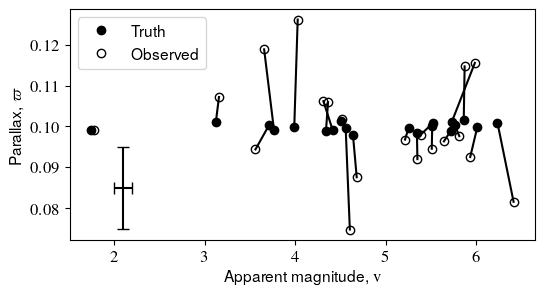

In [8]:
with plt.rc_context({"text.usetex": True}):
    fig, ax = plt.subplots(figsize=(6, 3))

    ax.plot(mag, par, "ok", label="Truth")
    ax.plot(mag_obs, par_obs, "ok", markerfacecolor="none", label="Observed")
    ax.plot(np.stack([mag, mag_obs]), np.stack([par, par_obs]), "k")
    ax.errorbar(2.1, 0.085, xerr=sigma_mag, yerr=sigma_par, color="k", capsize=4)

    ax.set_xlabel(r"Apparent magnitude, $\mathrm{v}$")
    ax.set_ylabel(r"Parallax, $\varpi$")
    ax.legend(loc="upper left")

In [10]:
def simple_model(par_obs=None, mag_obs=None):
    d = numpyro.sample("d", dist.Uniform(0., 20.), sample_shape=shape)
    abs_mag = numpyro.sample("abs_mag", dist.Normal(0., 10.), sample_shape=shape)
    
    par = numpyro.deterministic("par", 1/d)
    mag = numpyro.deterministic("mag", abs_mag + 5.0 * jnp.log10(d))
    
    numpyro.sample("par_obs", dist.Normal(par, sigma_par), obs=par_obs)
    numpyro.sample("mag_obs", dist.Normal(mag, sigma_mag), obs=mag_obs)

In [11]:
sampler = NUTS(simple_model)
mcmc = MCMC(sampler, num_warmup=500, num_samples=1000, num_chains=10)

In [12]:
rng, key = random.split(rng)
mcmc.run(key, par_obs=par_obs, mag_obs=mag_obs)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [13]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 abs_mag[0]     -1.63      0.27     -1.62     -2.06     -1.18   9922.83      1.00
 abs_mag[1]      0.10      0.27      0.12     -0.32      0.55  10853.91      1.00
 abs_mag[2]     -0.56      0.23     -0.56     -0.94     -0.18  11280.17      1.00
 abs_mag[3]      1.26      0.22      1.27      0.90      1.63  10622.44      1.00
 abs_mag[4]      0.50      0.26      0.51      0.07      0.94  10760.37      1.00
 abs_mag[5]      0.08      0.25      0.09     -0.33      0.50   9383.81      1.00
 abs_mag[6]      0.32      0.26      0.33     -0.12      0.74   8231.94      1.00
 abs_mag[7]     -3.29      0.25     -3.28     -3.69     -2.88  11251.20      1.00
 abs_mag[8]     -0.68      0.28     -0.67     -1.15     -0.22   9727.48      1.00
 abs_mag[9]     -0.50      0.24     -0.49     -0.90     -0.11  10645.08      1.00
abs_mag[10]     -0.50      0.20     -0.50     -0.83     -0.18  13004.77      1.00
abs_mag[11]    

In [14]:
coords = {"Star": np.arange(num_obs)}
dims = {
    "d": ["Star"], 
    "mag": ["Star"], 
    "abs_mag": ["Star"], 
    "par": ["Star"],
    "par_obs": ["Star"],
    "mag_obs": ["Star"]
}

samples_simple = mcmc.get_samples()
data_simple = az.from_numpyro(mcmc, coords=coords, dims=dims)
data_simple

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

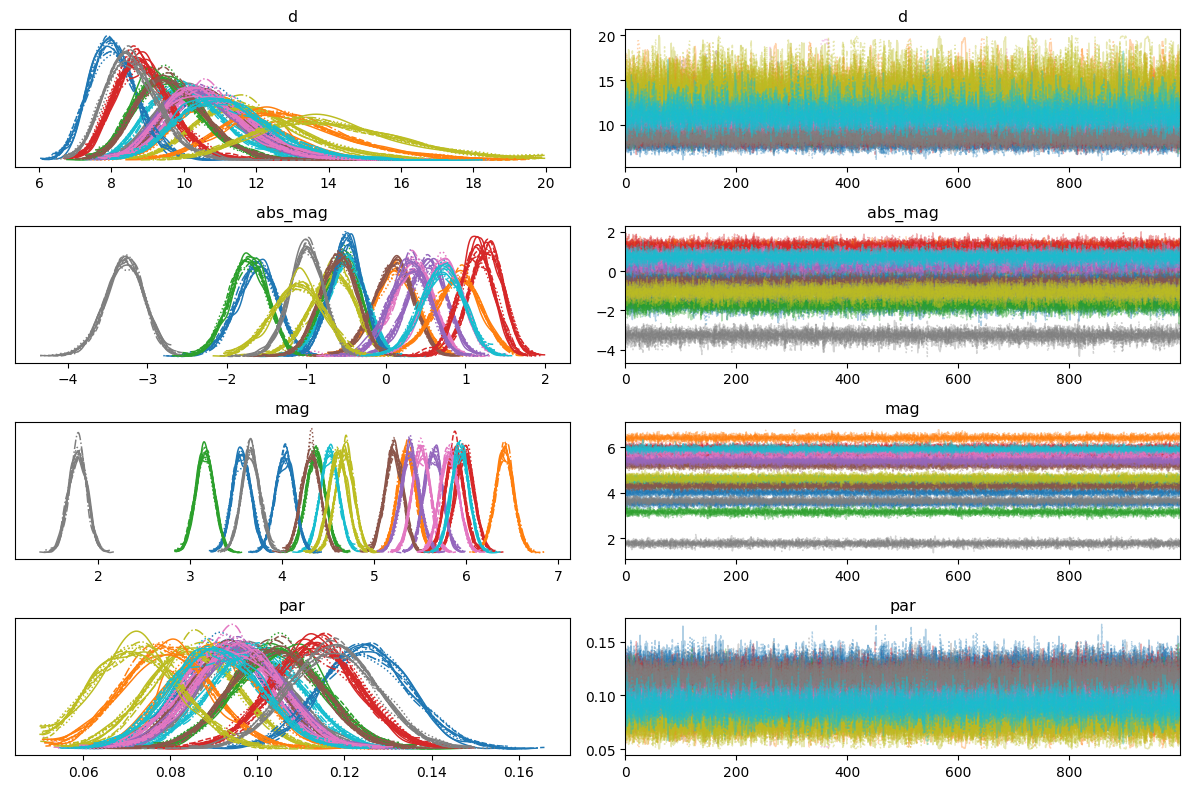

In [9]:
var_names = ["d", "abs_mag", "mag", "par"]
ax = az.plot_trace(data_simple, var_names=var_names)
plt.gcf().tight_layout()

In [15]:
def hierarchical_model(par_obs=None, mag_obs=None):
    mu_d = numpyro.sample("mu_d", dist.Uniform(0., 20.))
    sigma_d = numpyro.sample("sigma_d", dist.LogNormal(jnp.log(0.1), 1.0))
    # sigma_d = numpyro.deterministic("sigma_d", jnp.exp(log_sigma_d))
    _d = numpyro.sample("_d", dist.Normal(), sample_shape=shape)
    d = numpyro.deterministic("d", mu_d + sigma_d * _d)
    
    abs_mag = numpyro.sample("abs_mag", dist.Normal(0., 10.), sample_shape=shape)
    
    par = numpyro.deterministic("par", 1/d)
    mag = numpyro.deterministic("mag", abs_mag + 5.0 * jnp.log10(d))
    
    numpyro.sample("par_obs", dist.Normal(par, sigma_par), obs=par_obs)
    numpyro.sample("mag_obs", dist.Normal(mag, sigma_mag), obs=mag_obs)

In [16]:
sampler = NUTS(hierarchical_model, target_accept_prob=0.98)
mcmc = MCMC(sampler, num_warmup=500, num_samples=1000, num_chains=10)

In [17]:
rng, key = random.split(rng)
mcmc.run(key, par_obs=par_obs, mag_obs=mag_obs)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [18]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      _d[0]      0.11      0.98      0.11     -1.52      1.71  10000.78      1.00
      _d[1]      0.14      0.98      0.15     -1.48      1.71  11012.69      1.00
      _d[2]     -0.11      0.97     -0.11     -1.71      1.47   9764.30      1.00
      _d[3]     -0.28      0.99     -0.30     -1.92      1.33   8296.46      1.00
      _d[4]      0.08      0.98      0.09     -1.51      1.71  11138.74      1.00
      _d[5]      0.07      0.98      0.09     -1.53      1.64  11312.05      1.00
      _d[6]      0.09      0.98      0.09     -1.47      1.73  10438.25      1.00
      _d[7]      0.02      0.97     -0.00     -1.59      1.64  10942.38      1.00
      _d[8]      0.22      0.98      0.23     -1.40      1.80  10085.33      1.00
      _d[9]     -0.02      0.95     -0.02     -1.50      1.62  10873.09      1.00
     _d[10]     -0.48      1.05     -0.48     -2.20      1.23   4572.96      1.00
     _d[11]    

In [19]:
dims["_d"] = ["Star"]

samples_hbm = mcmc.get_samples()
data_hbm = az.from_numpyro(mcmc, coords=coords, dims=dims)
data_hbm

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

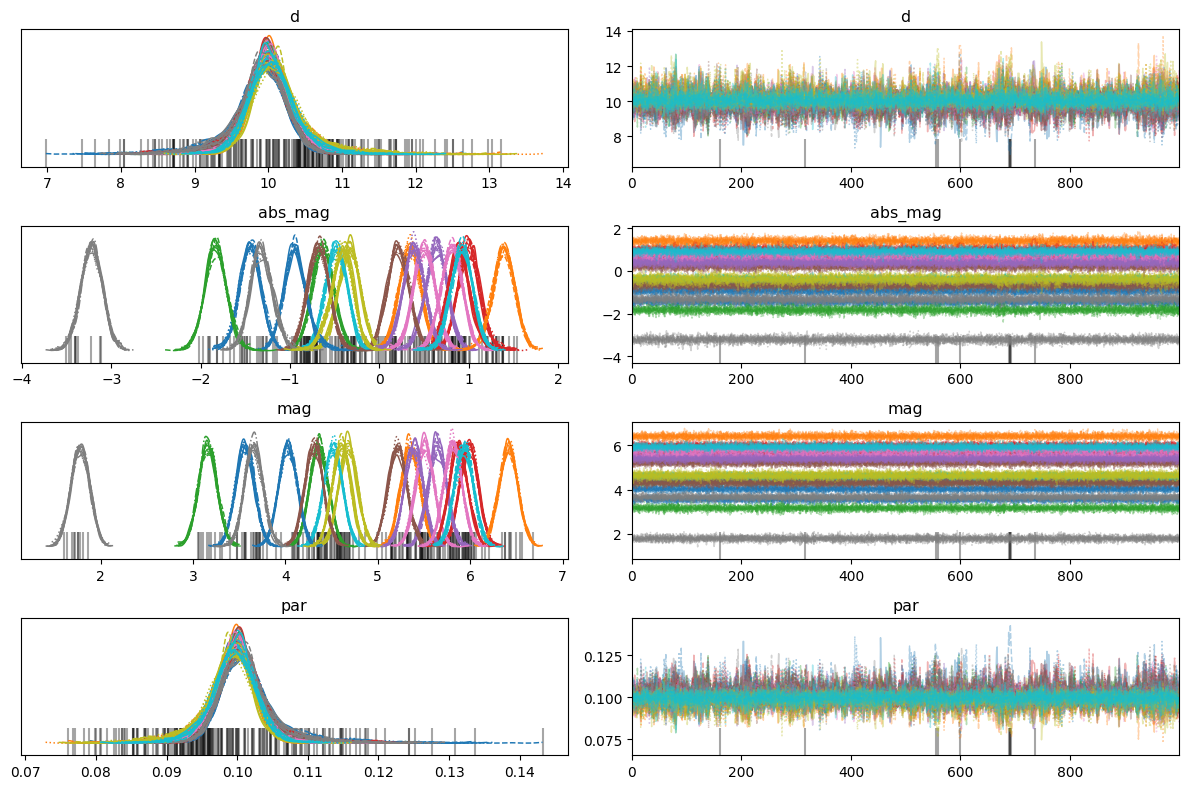

In [15]:
ax = az.plot_trace(data_hbm, var_names=var_names)
plt.gcf().tight_layout()

In [20]:
df = pd.concat(
    {
        "Simple": data_simple.posterior.to_dataframe(), 
        "HBM": data_hbm.posterior.to_dataframe()
    },
    names=["Model"]
).reset_index()
df.head()

,Model,chain,draw,Star,abs_mag,d,mag,par,_d,mu_d,sigma_d
0,Simple,0,0,0,-1.495262,10.047164,3.514955,0.099531,NaN,NaN,NaN
1,Simple,0,0,1,0.126995,10.949833,5.324032,0.091326,NaN,NaN,NaN
2,Simple,0,0,2,-0.632661,10.024597,4.372674,0.099755,NaN,NaN,NaN
3,Simple,0,0,3,1.315576,8.529445,5.970180,0.117241,NaN,NaN,NaN
4,Simple,0,0,4,0.503493,10.399219,5.588496,0.096161,NaN,NaN,NaN


TODO: Consider common_norm=False in KDE.

In [21]:
def plot_summary(df, y, truth=None, ylabel=None, legend=True, axes=None):
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(6.4, 3.2), sharey=True,
                                gridspec_kw={"width_ratios": [3, 1], "wspace": 0.06})
    else:
        fig = plt.gcf()

    ax = sns.violinplot(
        df, x="Star", y=y, hue="Model", saturation=1.0,
        scale="width", split=True, linewidth=0., ax=axes[0]
    )
    
    if truth is not None:
        star = np.arange(num_obs)
        ax.plot(star, truth, ".k", label="Truth")
        # ax.legend()
    
    if not legend:
        ax.get_legend().remove()
    
    ax = sns.kdeplot(df, y=y, hue="Model", ax=axes[1], legend=legend)
    ax.set_xticks([])
    ax.set_xlabel(None)
    if ylabel is not None:
        for ax in axes:
            ax.set_ylabel(ylabel)

    return fig, axes

def plot_residual(df, y, truth, obs=None, ylabel=None, legend=True, axes=None):
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(6.4, 3.2), sharey=True,
                                gridspec_kw={"width_ratios": [3, 1], "wspace": 0.06})
    else:
        fig = plt.gcf()
    
    star = np.arange(num_obs)
    truth = pd.Series(truth, index=pd.Index(star, name="Star"))
    df = df.copy().set_index("Star")
    df.loc[truth.index, y] -= truth
    df = df.reset_index()
    ax = sns.violinplot(
        df, x="Star", y=y, hue="Model", saturation=1.0,
        scale="width", split=True, linewidth=0., ax=axes[0]
    )
    
    if obs is not None:
        ax.plot(star, obs-truth, ".k", label="Observed", markerfacecolor="none")
        # ax.legend()
    
    if not legend:
        ax.get_legend().remove()
    
    ax = sns.kdeplot(df, y=y, hue="Model", fill=True, ax=axes[1], legend=legend)
    ax.set_xticks([])
    ax.set_xlabel(None)
    if ylabel is not None:
        for ax in axes:
            ax.set_ylabel(ylabel)

    return fig, axes

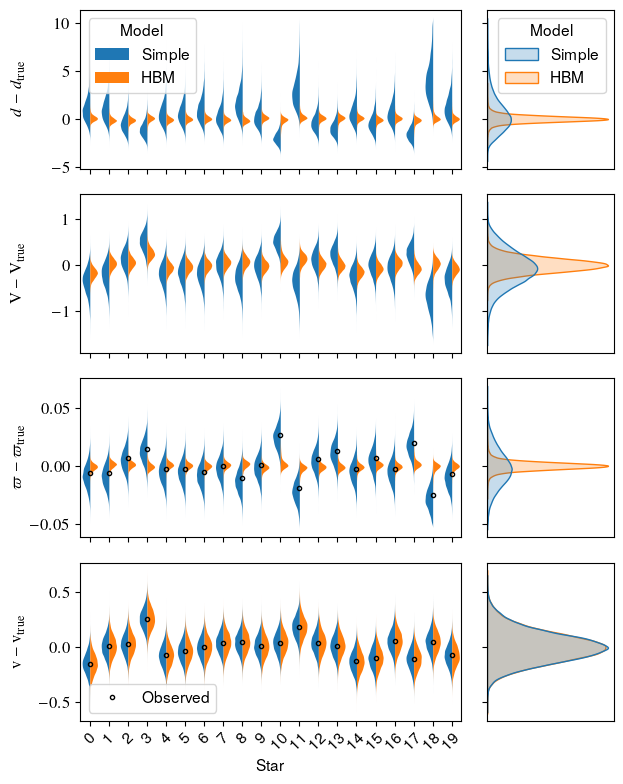

In [22]:
labelrotation = 45
with plt.rc_context({
    "text.usetex": True,  # Takes bloody ages for first time but good for thesis
}):
    fig, axes = plt.subplots(4, 2, figsize=(6.4, 8), sharey="row",
                            gridspec_kw={"width_ratios": [3, 1]})

    ax0 = axes[-1]
    _, ax0 = plot_residual(df, "mag", mag, obs=mag_obs, ylabel=r"$\mathrm{v} - \mathrm{v_{true}}$", axes=ax0, legend=False)
    ax0[0].tick_params(axis='x', labelrotation=labelrotation)
    ax0[0].legend(handles=[ax0[0].get_lines()[-1]], loc="lower left")

    ax = axes[-2]
    ax[0].sharex(ax0[0])
    _, ax = plot_residual(df, "par", par, obs=par_obs, ylabel=r"$\varpi - \varpi_\mathrm{true}$", axes=ax, legend=False)
    ax[0].set_xlabel(None)
    ax[0].tick_params(axis='x', labelbottom=False)

    ax = axes[-3]
    ax[0].sharex(ax0[0])
    _, ax = plot_residual(df, "abs_mag", abs_mag, ylabel=r"$\mathrm{V} - \mathrm{V_{true}}$", axes=ax, legend=False)
    ax[0].set_xlabel(None)
    ax[0].tick_params(axis='x', labelbottom=False)

    ax = axes[-4]
    ax[0].sharex(ax0[0])
    _, ax = plot_residual(df, "d", d, ylabel=r"$d - d_\mathrm{true}$", axes=ax)
    ax[0].set_xlabel(None)
    ax[0].tick_params(axis='x', labelbottom=False)
    fig.align_ylabels()
    fig.tight_layout()
    fig.savefig("../figures/hbm-results.pdf", format="pdf", dpi=300)

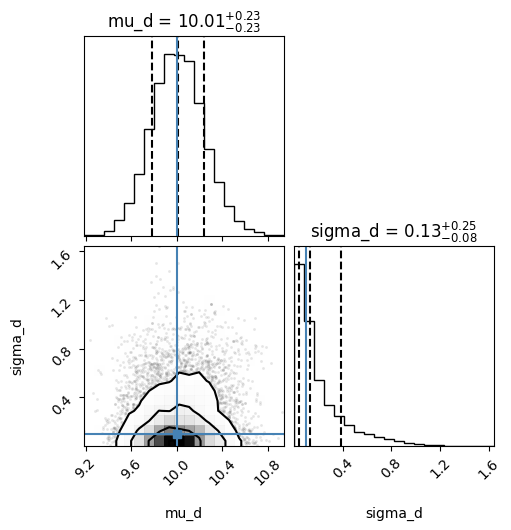

In [29]:
fig = corner(
    data_hbm, 
    var_names=["mu_d", "sigma_d"], 
    truths={"mu_d": mu_d, "sigma_d": sigma_d},
    show_titles=True,
    quantiles=[.16, .5, .84]
)

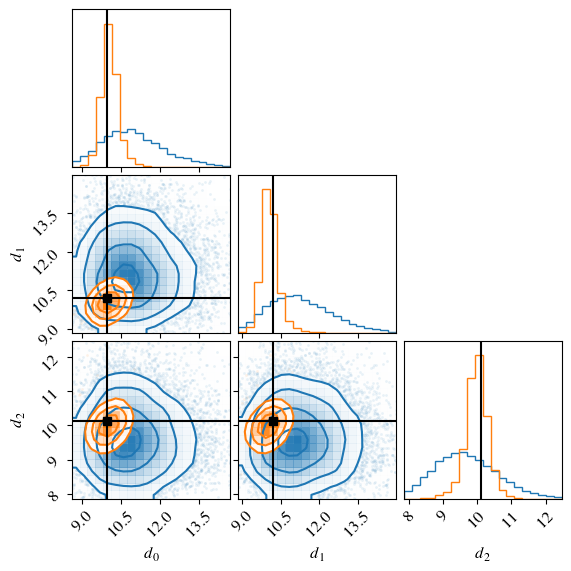

In [77]:
ndim = 3
stars = np.arange(ndim)
var_names = ["d"]
labels = [f"$d_{i}$" for i in stars]
coords = {"Star": stars}
rlim = data_simple.posterior.d.sel(Star=stars).quantile(
    [.01, .99], dim=("chain", "draw")
).T
smooth = 1

with plt.rc_context({
    "text.usetex": True,  # Takes bloody ages for first time but good for thesis
}):
    fig = plt.figure(figsize=(6, 6))
    fig = corner(
        data_simple, 
        var_names=var_names,
        labels=labels,
        coords=coords,
        smooth=smooth,
        range=rlim,
        color="C0",
        fig=fig,
    )

    fig = corner(
        data_hbm, 
        var_names=var_names,
        labels=labels,
        coords=coords,
        range=rlim,
        smooth=smooth,
        color="C1",
        truths={"d": d[stars]},
        truth_color="k",
        fig=fig,
    )

    # neat bit of code for setting limits after the fact
    # prob easier/slower to just reshape the axes though lol
    ti, tj = np.tril_indices(ndim)
    ltri = ndim*ti + tj
    di, dj = np.diag_indices(ndim)
    diag = ndim*di + dj
    for i, ax in enumerate(fig.get_axes()):
        if i not in ltri:
            # continue if not in lower triangle
            continue
        ax.set_xlim(rlim[i%ndim])
        if i not in diag:
            # ylim of diag should be unchanged
            ax.set_ylim(rlim[i//ndim])

    fig.savefig("../figures/hbm-dist-corr.pdf", format="pdf", dpi=300)

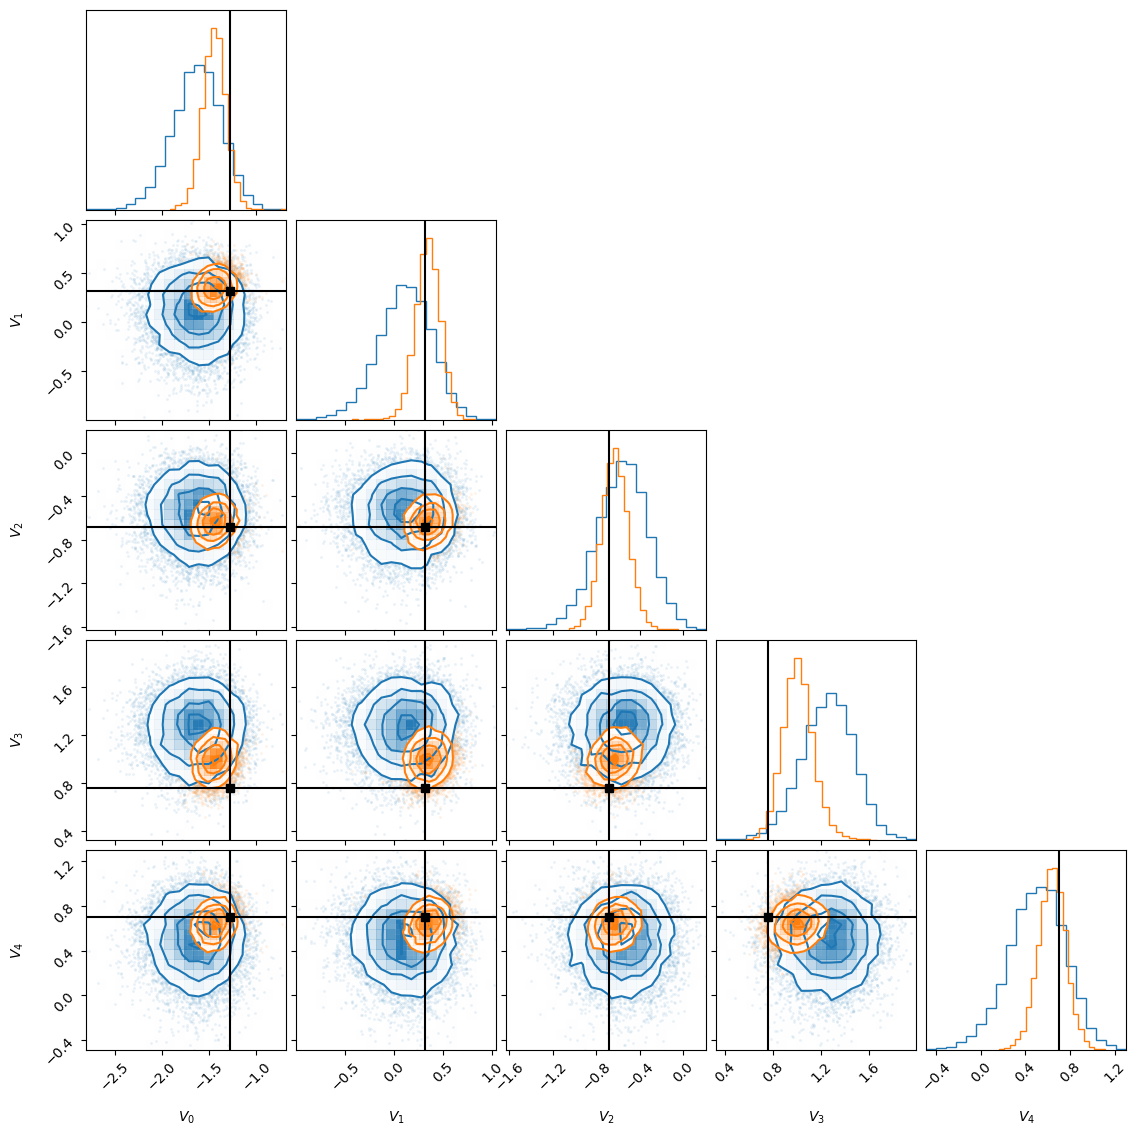

In [31]:
stars = np.arange(5)
var_names = ["abs_mag"]
labels = [f"$V_{i}$" for i in stars]
coords = {"Star": stars}

fig = corner(
    data_simple, 
    var_names=var_names,
    labels=labels,
    coords=coords,
    color="C0",
)

fig = corner(
    data_hbm, 
    var_names=var_names,
    labels=labels,
    coords=coords,
    color="C1",
    truths={"abs_mag": abs_mag[stars]},
    truth_color="k",
    fig=fig
)

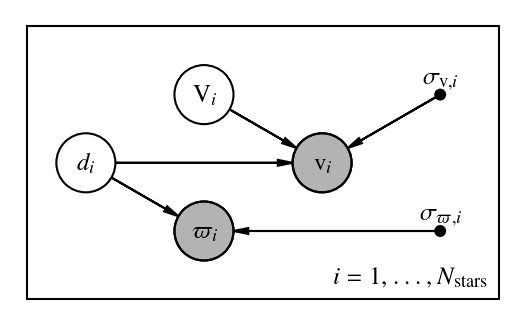

In [23]:
ux = 1
uy = 1 / np.sqrt(3)
plot_params = {"facecolor": "white"}

with plt.rc_context({
    "font.size": 12,
    "text.usetex": True,
}):
    # Instantiate the PGM.
    pgm = daft.PGM()

    # Parameters
    pgm.add_node("d", r"$d_i$", 0, 0, plot_params=plot_params)
    pgm.add_node("abs_mag", r"$\mathrm{V}_i$", ux, uy, plot_params=plot_params)
    pgm.add_node("mag", r"$\mathrm{v}_i$", 2*ux, 0, observed=True)
    pgm.add_node("par", r"$\varpi_i$", ux, -uy, observed=True)

    # Uncertainties
    pgm.add_node("sigma_mag", r"$\sigma_{\mathrm{v},i}$", 3*ux, uy, fixed=True)
    pgm.add_node("sigma_par", r"$\sigma_{\varpi,i}$", 3*ux, -uy, fixed=True)

    pgm.add_edge("d", "mag")
    pgm.add_edge("d", "par")
    pgm.add_edge("abs_mag", "mag")
    pgm.add_edge("sigma_mag", "mag")
    pgm.add_edge("sigma_par", "par")

    pgm.add_plate([-ux/2, -2*uy, 4*ux, 4*uy], label=r"$i=1,\dots,N_\mathrm{stars}$", position='bottom right')

    # px = 4*ux
    # dx = 4.3*ux
    # pgm.add_text(px, 1.4*uy, pgm._nodes["d"].content)
    # pgm.add_text(dx, 1.4*uy, r"$\sim \mathcal{U}\,(0, 20)$")
    # pgm.add_text(px, 0.4*uy, pgm._nodes["abs_mag"].content)
    # pgm.add_text(dx, 0.4*uy, r"$\sim \mathcal{N}\,(0, 100)$")
    # pgm.add_text(px, -0.6*uy, pgm._nodes["par"].content)
    # pgm.add_text(dx, -0.6*uy, r"$\sim \mathcal{N}\,(d_i^{-1}, \sigma_{\varpi,i}^2)$")
    # pgm.add_text(px, -1.6*uy, pgm._nodes["mag"].content)
    # pgm.add_text(dx, -1.6*uy, r"$\sim \mathcal{N}\,(\mathrm{V}_i + 5\log_{10}d_i, \sigma_{\mathrm{v},i}^2)$")

    pgm.render(dpi=150)
    pgm.savefig("../figures/simple-pgm.pdf", format="pdf", dpi=300)

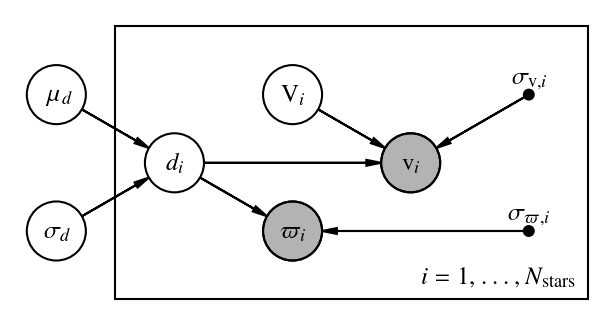

In [24]:
# Instantiate the PGM.
with plt.rc_context({
    # "mathtext.fontset": "dejavuserif",
    "font.size": 12,
    "text.usetex": True,
}):
    pgm = daft.PGM()

    # Hyperparameters
    pgm.add_node("mu_d", r"$\mu_d$", -ux, uy, plot_params=plot_params)
    pgm.add_node("sigma_d", r"$\sigma_d$", -ux, -uy, plot_params=plot_params)

    # Parameters
    pgm.add_node("d", r"$d_i$", 0, 0, plot_params=plot_params)
    pgm.add_node("abs_mag", r"$\mathrm{V}_i$", 1, uy, plot_params=plot_params)
    pgm.add_node("mag", r"$\mathrm{v}_i$", 2*ux, 0, observed=True)
    pgm.add_node("par", r"$\varpi_i$", ux, -uy, observed=True)

    # Uncertainties
    pgm.add_node("sigma_mag", r"$\sigma_{\mathrm{v},i}$", 3*ux, uy, fixed=True)
    pgm.add_node("sigma_par", r"$\sigma_{\varpi,i}$", 3*ux, -uy, fixed=True)


    pgm.add_edge("mu_d", "d")
    pgm.add_edge("sigma_d", "d")

    pgm.add_edge("d", "mag")
    pgm.add_edge("d", "par")
    pgm.add_edge("abs_mag", "mag")
    pgm.add_edge("sigma_mag", "mag")
    pgm.add_edge("sigma_par", "par")

    pgm.add_plate([-ux/2, -2*uy, 4*ux, 4*uy], label=r"$i=1,\dots,N_\mathrm{stars}$", position='bottom right')
    
    # px = 4*ux
    # dx = 4.5*ux
    # pgm.add_text(px, 0.9*uy, pgm._nodes["mu_d"].content)
    # pgm.add_text(dx, 0.9*uy, r"$\sim \mathcal{U}\,(0, 20)$")

    # pgm.add_text(px, -0.1, r"$\ln\,$"+pgm._nodes["sigma_d"].content)
    # pgm.add_text(dx, -0.1, r"$\sim \mathcal{N}\,(-\ln(10), 1)$")

    # pgm.add_text(px, -1.1*uy, pgm._nodes["d"].content)
    # pgm.add_text(dx, -1.1*uy, r"$\sim \mathcal{N}(\mu_d, \sigma_d^2)$")

    pgm.render(dpi=150)
    pgm.savefig("../figures/hbm-pgm.pdf", format="pdf", dpi=300)

<Axes: >

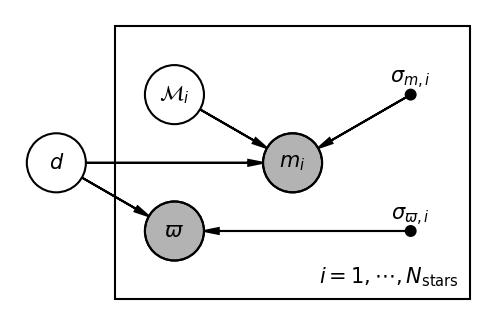

In [185]:
# Instantiate the PGM.
pgm = daft.PGM()

# Parameters
pgm.add_node("d", r"$d$", 0, 0)
pgm.add_node("abs_mag", r"$\mathcal{M}_i$", ux, uy)
pgm.add_node("mag", r"$m_i$", 2*ux, 0, observed=True)
pgm.add_node("par", r"$\varpi$", ux, -uy, observed=True)

# Uncertainties
pgm.add_node("sigma_mag", r"$\sigma_{m,i}$", 3*ux, uy, fixed=True)
pgm.add_node("sigma_par", r"$\sigma_{\varpi,i}$", 3*ux, -uy, fixed=True)

pgm.add_edge("d", "mag")
pgm.add_edge("d", "par")
pgm.add_edge("abs_mag", "mag")
pgm.add_edge("sigma_mag", "mag")
pgm.add_edge("sigma_par", "par")

pgm.add_plate([ux/2, -2*uy, 3*ux, 4*uy], label=r"$i=1,\cdots,N_\mathrm{stars}$", 
              position='bottom right')
pgm.render(dpi=150)

In [112]:
az.summary(data_hbm, var_names=["mu_d", "sigma_d"], 
           stat_funcs={"med": np.median, "16": lambda a: np.median(a) - np.quantile(a, .16), 
                       "84": lambda a: np.quantile(a, .84) - np.median(a)})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,med,16,84
mu_d,10.014,0.236,9.585,10.464,0.004,0.003,3125.0,3589.0,1.00,10.007,0.226,0.242
sigma_d,0.217,0.225,0.003,0.664,0.008,0.005,1254.0,1304.0,1.01,0.131,0.088,0.280


In [106]:
data_simple.posterior.d.std(dim=("chain", "draw"))

<xarray.DataArray 'd' (Star: 20)>
array([1.2878505 , 1.3159256 , 0.9713126 , 0.81990707, 1.2181237 ,
       1.177779  , 1.2598491 , 1.1153708 , 1.4863569 , 1.0530798 ,
       0.6620005 , 1.691295  , 0.936177  , 0.8269238 , 1.1515802 ,
       0.980719  , 1.1637403 , 0.76563025, 1.9991618 , 1.3060532 ],
      dtype=float32)
Coordinates:
  * Star     (Star) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

In [102]:
data_simple.posterior.d.std()

<xarray.DataArray 'd' ()>
array(1.8445239, dtype=float32)

In [119]:
data_simple.posterior.d.std(dim=("chain", "draw"))

<xarray.DataArray 'd' (Star: 20)>
array([1.2878505 , 1.3159256 , 0.9713126 , 0.81990707, 1.2181237 ,
       1.177779  , 1.2598491 , 1.1153708 , 1.4863569 , 1.0530798 ,
       0.6620005 , 1.691295  , 0.936177  , 0.8269238 , 1.1515802 ,
       0.980719  , 1.1637403 , 0.76563025, 1.9991618 , 1.3060532 ],
      dtype=float32)
Coordinates:
  * Star     (Star) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

In [101]:
data_simple.posterior.d.mean(dim=("chain", "draw")).std(ddof=1)/np.sqrt(num_obs)

<xarray.DataArray 'd' ()>
array(0.32130019)

In [91]:
data_hbm.posterior.d.mean()

<xarray.DataArray 'd' ()>
array(10.013573, dtype=float32)

In [118]:
data_hbm.posterior.d.mean(dim=("chain", "draw")).std(ddof=1)/np.sqrt(num_obs)

<xarray.DataArray 'd' ()>
array(0.01946994)

In [121]:
data_hbm.posterior.d.std(dim=("chain", "draw"))

<xarray.DataArray 'd' (Star: 20)>
array([0.35246223, 0.36221865, 0.34166592, 0.37113568, 0.342611  ,
       0.3428065 , 0.34993857, 0.33686543, 0.36783525, 0.3419139 ,
       0.43830448, 0.3960769 , 0.34464914, 0.3659979 , 0.3436674 ,
       0.33932608, 0.3497111 , 0.38968304, 0.45284548, 0.35922018],
      dtype=float32)
Coordinates:
  * Star     (Star) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

In [122]:
data_hbm.posterior.abs_mag.std(dim=("chain", "draw"))

<xarray.DataArray 'abs_mag' (Star: 20)>
array([0.12413704, 0.1261531 , 0.12636393, 0.13092454, 0.12261362,
       0.12553848, 0.12558618, 0.12285243, 0.12642543, 0.12412277,
       0.14221926, 0.1292994 , 0.12624422, 0.12691998, 0.12483485,
       0.12512885, 0.12692316, 0.1338972 , 0.13875784, 0.12656708],
      dtype=float32)
Coordinates:
  * Star     (Star) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

In [123]:
data_hbm.posterior.par.std(dim=("chain", "draw"))

<xarray.DataArray 'par' (Star: 20)>
array([0.00341428, 0.00347057, 0.00350306, 0.00395281, 0.00336965,
       0.00335985, 0.00339625, 0.00334067, 0.00348764, 0.00339603,
       0.0048951 , 0.00367051, 0.00351542, 0.00389862, 0.00339625,
       0.00346765, 0.00341588, 0.00424153, 0.00407031, 0.00345657],
      dtype=float32)
Coordinates:
  * Star     (Star) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

In [125]:
data_simple.posterior.par.std(dim=("chain", "draw"))

<xarray.DataArray 'par' (Star: 20)>
array([0.01033361, 0.0101073 , 0.01010003, 0.01023516, 0.01033446,
       0.0100608 , 0.0102262 , 0.01006844, 0.01024098, 0.01003106,
       0.00996615, 0.00989971, 0.01004608, 0.01015859, 0.01008306,
       0.01019443, 0.01016184, 0.01017556, 0.00995367, 0.01010331],
      dtype=float32)
Coordinates:
  * Star     (Star) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19